In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from pathlib import Path
import pandas as pd
from tqdm import tqdm

from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression

import matplotlib.pyplot as plt
import seaborn as sns
MONTH = 21
YEAR = 12 * MONTH
START = '2001-01-01'
END = '2017-12-31'
sns.set_style('white')
idx = pd.IndexSlice

results_path = Path('results', 'cnn_for_trading')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [2]:
with pd.HDFStore('data/universe_data.h5') as store:
    features = store.get('features')
    targets = store.get('targets')

features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2416051 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2018-03-27 00:00:00'))
Columns: 300 entries, 06_RSI to 85_CMA
dtypes: float64(300)
memory usage: 5.4+ GB


In [3]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2416051 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2018-03-27 00:00:00'))
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   r01_fwd     float64
 1   r01dec_fwd  float64
 2   r05_fwd     float64
 3   r05dec_fwd  float64
dtypes: float64(4)
memory usage: 83.1+ MB


In [4]:
features.shape, targets.shape

((2416051, 300), (2416051, 4))

In [5]:
features.head(10)

06_RSI     07_RSI     08_RSI     09_RSI     10_RSI  \
symbol date                                                                
A      2001-01-02  32.793601  35.473429  37.693632  39.545470  41.093660   
       2001-01-03  56.348597  55.564668  55.120419  54.877176  54.747910   
       2001-01-04  62.685884  61.248942  60.251136  59.538725  59.010846   
       2001-01-05  49.666159  50.016768  50.352086  50.676410  50.981262   
       2001-01-08  43.512726  44.602284  45.504127  46.279231  46.953408   
       2001-01-09  42.637162  43.837575  44.822895  45.663555  46.390917   
       2001-01-10  53.100948  52.598499  52.355133  52.264844  52.262282   
       2001-01-11  61.343044  59.735890  58.640151  57.873012  57.321025   
       2001-01-12  54.092871  53.736376  53.512794  53.388298  53.330178   
       2001-01-16  61.881057  60.417663  59.362671  58.588958  58.009577   

                      11_RSI     12_RSI     13_RSI     14_RSI     15_RSI  ...  \
symbol date                                                               ...   
A      2001-01-02  42.389606  43.475721  44.387250  45.153419  45.798372  ...   
       2001-01-03  54.679264  54.639285  54.609352  54.579004  54.542703  ...   
       2001-01-04  58.601987  58.269917  57.987531  57.737465  57.508594  ...   
       2001-01-05  51.258474  51.503174  51.713622  51.890310  52.035085  ...   
       2001-01-08  47.540265  48.049357  48.488875  48.866393  49.188973  ...   
       2001-01-09  47.022034  47.568698  48.040622  48.446449  48.794018  ...   
       2001-01-10  52.306333  52.371317  52.441534  52.507712  52.564669  ...   
       2001-01-11  56.911225  56.595843  56.343309  56.132638  55.949813  ...   
       2001-01-12  53.312614  53.317024  53.330802  53.345783  53.356931  ...   
       2001-01-16  57.564576  57.212574  56.925018  56.682206  56.470525  ...   

                   80_Market    80_SMB    80_HML    80_RMW    80_CMA  \
symbol date                                                            
A      2001-01-02   0.019140  0.009963 -0.000408 -0.001217  0.001485   
       2001-01-03   0.019199  0.009584 -0.000394 -0.001102  0.001435   
       2001-01-04   0.018521  0.011031  0.000425 -0.000463 -0.000928   
       2001-01-05   0.018478  0.011120 -0.000795 -0.000095 -0.000232   
       2001-01-08   0.018028  0.011065 -0.001719 -0.000168  0.000079   
       2001-01-09   0.018113  0.011086 -0.001895  0.000203  0.000130   
       2001-01-10   0.018507  0.011805 -0.003109  0.001565  0.000240   
       2001-01-11   0.017907  0.010973 -0.003605  0.001655  0.000130   
       2001-01-12   0.017672  0.009271 -0.003568  0.001977 -0.000654   
       2001-01-16   0.017112  0.009475 -0.005162  0.002735 -0.000571   

                   85_Market    85_SMB    85_HML        85_RMW    85_CMA  
symbol date                                                               
A      2001-01-02   0.018587  0.009645 -0.000773 -1.220027e-03  0.001228  
       2001-01-03   0.018900  0.009850 -0.001061 -9.698170e-04  0.001320  
       2001-01-04   0.017621  0.011203 -0.001869  8.143780e-07 -0.000628  
       2001-01-05   0.017589  0.010891 -0.002378  1.786962e-04 -0.000481  
       2001-01-08   0.017581  0.011446 -0.002328  1.820646e-04 -0.000575  
       2001-01-09   0.017642  0.011293 -0.002304  4.303781e-04 -0.000591  
       2001-01-10   0.017727  0.010979 -0.002302  2.940213e-04 -0.000237  
       2001-01-11   0.018373  0.010954 -0.000594 -5.348053e-05 -0.000622  
       2001-01-12   0.018716  0.010288 -0.000860  6.144773e-04 -0.000386  
       2001-01-16   0.018753  0.010374 -0.000974  6.044887e-04 -0.000250  

[10 rows x 300 columns]

In [6]:
targets.head(10)

r01_fwd  r01dec_fwd   r05_fwd  r05dec_fwd
symbol date                                                  
A      2001-01-02  0.103184         7.0  0.041667         6.0
       2001-01-03  0.037769         8.0 -0.014609         5.0
       2001-01-04 -0.054764         2.0 -0.011845         4.0
       2001-01-05 -0.032873         1.0  0.019433         5.0
       2001-01-08 -0.004695         4.0  0.092770         7.0
       2001-01-09  0.043585         8.0  0.168679         8.0
       2001-01-10  0.040680         7.0  0.221479         9.0
       2001-01-11 -0.024844         2.0  0.138985         9.0
       2001-01-12  0.036701         8.0  0.117940         9.0
       2001-01-16  0.064444         9.0  0.078364         7.0

In [7]:
# Select Features using Mutual Information
mi = {}
for t in tqdm([1, 5]):
    target = f'r{t:02}_fwd'
    # sample a smaller number to speed up the computation
    df = features.join(targets[target]).dropna().sample(n=100000)
    X = df.drop(target, axis=1)
    y = df[target]
    mi[t] = pd.Series(mutual_info_regression(X=X, y=y), index=X.columns).sort_values(ascending=False)

100%|██████████| 2/2 [10:45<00:00, 322.96s/it]


In [8]:
pd.concat([X.head(), X.tail()])

,,06_RSI,07_RSI,08_RSI,09_RSI,10_RSI,11_RSI,12_RSI,13_RSI,14_RSI,15_RSI,...,80_Market,80_SMB,80_HML,80_RMW,80_CMA,85_Market,85_SMB,85_HML,85_RMW,85_CMA
symbol,date,,,,,,,,,,,,,,,,,,,,,
EA,2011-08-22,47.725436,46.096107,44.812150,43.809519,43.033189,42.438172,41.988592,41.656092,41.418257,41.257285,...,0.012487,0.000672,-0.006960,0.003638,0.007831,0.012218,0.001477,-0.005338,0.004293,0.003861
AMD,2007-03-08,37.303864,36.997573,36.649297,36.253906,35.837072,35.425795,35.040409,34.693789,34.392736,34.139705,...,0.009981,-0.000796,-0.014911,0.002658,0.016938,0.010346,-0.001182,-0.016312,0.000852,0.015990
KBR,2011-04-05,67.914798,67.571127,67.087734,66.561558,66.043054,65.556208,65.110686,64.708700,64.348768,64.027735,...,0.018985,-0.001087,-0.006758,-0.003169,0.009445,0.019324,-0.000446,-0.007929,-0.002021,0.008778
TER,2012-01-09,82.092910,78.737765,75.895847,73.484598,71.431632,69.676642,68.169770,66.869751,65.742386,64.759333,...,0.013158,0.002759,-0.013458,-0.017407,0.004088,0.012368,0.003208,-0.012080,-0.017867,0.000752
CAH,2017-04-13,43.139443,44.871572,46.146055,47.175102,48.060439,48.850870,49.569782,50.228528,50.832937,51.386458,...,0.012984,0.002973,-0.007550,0.001795,-0.003377,0.012521,0.002662,-0.007979,0.000504,-0.001401
YUM,2012-10-19,52.999307,54.656120,55.727539,56.446588,56.940470,57.282600,57.517628,57.674045,57.770857,57.821300,...,0.008470,0.004575,-0.006468,-0.006228,0.008634,0.008568,0.004558,-0.006740,-0.004106,0.009112
MS,2009-12-15,35.440160,35.818797,36.282830,36.810098,37.375197,37.956724,38.538703,39.110061,39.663602,40.194998,...,0.008733,0.005656,0.013179,0.000368,-0.013677,0.008528,0.005383,0.012708,0.000647,-0.012544
DTV,2015-04-23,80.309392,78.418578,76.752866,75.255351,73.897388,72.661848,71.536094,70.509309,69.571627,68.713929,...,0.004719,-0.001571,0.000572,0.002867,0.000906,0.004831,-0.001432,0.000405,0.003111,0.001441
RAI,2017-03-17,81.195678,78.822286,77.033907,75.695822,74.696619,73.948466,73.383917,72.952061,72.614945,72.344533,...,0.004526,-0.000686,-0.001939,0.003889,0.001491,0.004997,-0.001373,-0.002479,0.003220,0.001943


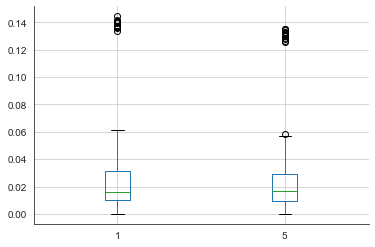

In [9]:
mutual_info = pd.DataFrame(mi)
mutual_info.to_hdf('data/universe_data.h5', 'mutual_info')
mutual_info = pd.read_hdf('data/universe_data.h5', 'mutual_info')
mi_by_indicator = (mutual_info.groupby(mutual_info.index.to_series().str.split('_').str[-1]).mean()
                   .rank(ascending=False).sort_values(by=1))
mutual_info.boxplot()
sns.despine();

In [31]:
mutual_info.groupby(mutual_info.index.to_series().str.split('_').str[-1])[1, 5].mean()

,1,5
ADOSC,0.006089,0.007317
ADX,0.001206,0.001963
BBH,0.057535,0.050721
BBL,0.029118,0.024141
CCI,0.006184,0.006192
CMA,0.014821,0.016817
CMO,0.015324,0.014531
EMA,0.030750,0.028747
HML,0.011330,0.011430
MACD,0.017396,0.014684


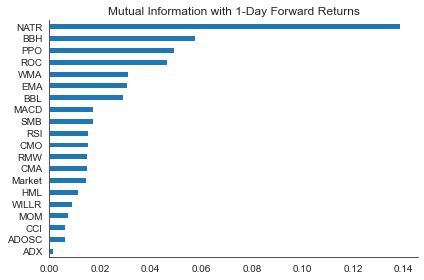

In [10]:
(mutual_info.groupby(mutual_info.index.to_series().str.split('_').str[-1])[1].mean()
 .sort_values().plot.barh(title='Mutual Information with 1-Day Forward Returns'))
sns.despine()
plt.tight_layout()
# plt.savefig(results_path / 'mutual_info_cnn_features', dpi=300)

In [40]:
mi_by_indicator.head(15).index

Index(['NATR', 'BBH', 'PPO', 'ROC', 'WMA', 'EMA', 'BBL', 'MACD', 'SMB', 'RSI',
       'CMO', 'RMW', 'CMA', 'Market', 'HML'],
      dtype='object')

In [11]:
best_features = mi_by_indicator.head(15).index
size = len(best_features)

# Hierarchical Feature Clustering
features = pd.concat([features.filter(like=f'_{f}') for f in best_features], axis=1)
new_cols = {}
for feature in best_features:
    fnames = sorted(features.filter(like=f'_{feature}').columns.tolist())
    renamed = [f'{i:02}_{feature}' for i in range(1, len(fnames)+ 1)]
    new_cols.update(dict(zip(fnames, renamed)))

features = features.rename(columns=new_cols).sort_index(1)
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2416051 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2018-03-27 00:00:00'))
Columns: 225 entries, 01_BBH to 15_WMA
dtypes: float64(225)
memory usage: 4.1+ GB


In [13]:
new_cols

{'06_NATR': '01_NATR',
 '07_NATR': '02_NATR',
 '08_NATR': '03_NATR',
 '09_NATR': '04_NATR',
 '10_NATR': '05_NATR',
 '11_NATR': '06_NATR',
 '12_NATR': '07_NATR',
 '13_NATR': '08_NATR',
 '14_NATR': '09_NATR',
 '15_NATR': '10_NATR',
 '16_NATR': '11_NATR',
 '17_NATR': '12_NATR',
 '18_NATR': '13_NATR',
 '19_NATR': '14_NATR',
 '20_NATR': '15_NATR',
 '06_BBH': '01_BBH',
 '07_BBH': '02_BBH',
 '08_BBH': '03_BBH',
 '09_BBH': '04_BBH',
 '10_BBH': '05_BBH',
 '11_BBH': '06_BBH',
 '12_BBH': '07_BBH',
 '13_BBH': '08_BBH',
 '14_BBH': '09_BBH',
 '15_BBH': '10_BBH',
 '16_BBH': '11_BBH',
 '17_BBH': '12_BBH',
 '18_BBH': '13_BBH',
 '19_BBH': '14_BBH',
 '20_BBH': '15_BBH',
 '06_PPO': '01_PPO',
 '07_PPO': '02_PPO',
 '08_PPO': '03_PPO',
 '09_PPO': '04_PPO',
 '10_PPO': '05_PPO',
 '11_PPO': '06_PPO',
 '12_PPO': '07_PPO',
 '13_PPO': '08_PPO',
 '14_PPO': '09_PPO',
 '15_PPO': '10_PPO',
 '16_PPO': '11_PPO',
 '17_PPO': '12_PPO',
 '18_PPO': '13_PPO',
 '19_PPO': '14_PPO',
 '20_PPO': '15_PPO',
 '06_ROC': '01_ROC',
 '07

In [18]:
features.tail()

01_CMO    01_ROC   01_NATR    01_PPO   01_MACD  \
symbol date                                                            
ZTS    2018-03-21  11.500512 -0.579265  1.839422  2.810751  2.371858   
       2018-03-22 -27.581970 -2.714879  2.044189  2.072431  1.971583   
       2018-03-23 -44.337906 -4.829378  2.247168  1.164358  1.442348   
       2018-03-26   9.519835 -1.028369  2.453539  1.345641  1.409570   
       2018-03-27 -13.594762 -1.551413  2.750986  0.955138  1.121832   

                     01_CMA    01_RMW    01_HML  01_Market    01_SMB  ...  \
symbol date                                                           ...   
ZTS    2018-03-21  0.002340  0.002342 -0.010770   0.009186 -0.005371  ...   
       2018-03-22  0.003041  0.004505 -0.010516   0.011582 -0.006142  ...   
       2018-03-23  0.002294  0.004565 -0.008518   0.011154 -0.007578  ...   
       2018-03-26  0.001158  0.001748 -0.007059   0.010987 -0.009854  ...   
       2018-03-27  0.000800  0.002722 -0.008496   0.012179 -0.005963  ...   

                     11_CMA    11_RMW    11_HML  11_Market    11_SMB  \
symbol date                                                            
ZTS    2018-03-21  0.000139  0.003458 -0.005068   0.009918  0.000578   
       2018-03-22 -0.001250  0.004155 -0.004228   0.010327  0.001235   
       2018-03-23 -0.000956  0.004032 -0.004427   0.010242  0.001077   
       2018-03-26 -0.002575  0.004021 -0.003738   0.010542  0.001202   
       2018-03-27 -0.003096  0.003429 -0.003976   0.010567  0.001346   

                     11_BBH    11_BBL     11_RSI     11_EMA     11_WMA  
symbol date                                                             
ZTS    2018-03-21  0.023354  0.047221  61.863701  83.051051  83.781691  
       2018-03-22  0.045243  0.021501  52.919235  82.934457  83.661176  
       2018-03-23  0.061055  0.003426  47.658897  82.659815  83.360074  
       2018-03-26  0.026100  0.036231  57.353024  82.785719  83.426029  
       2018-03-27  0.047084  0.014856  51.298294  82.676811  83.253971  

[5 rows x 225 columns]

In [14]:
# Hierarchical Clustering
def cluster_features(data, labels, ax, title):
    data = StandardScaler().fit_transform(data)
    pairwise_distance = pdist(data)
    Z = linkage(data, 'ward')
    c, coph_dists = cophenet(Z, pairwise_distance) # return cophenetic distance
    dend = dendrogram(Z, labels=labels, orientation='top', leaf_rotation=0., leaf_font_size=8., ax=ax)
    ax.set_title(title)
    return dend['ivl']

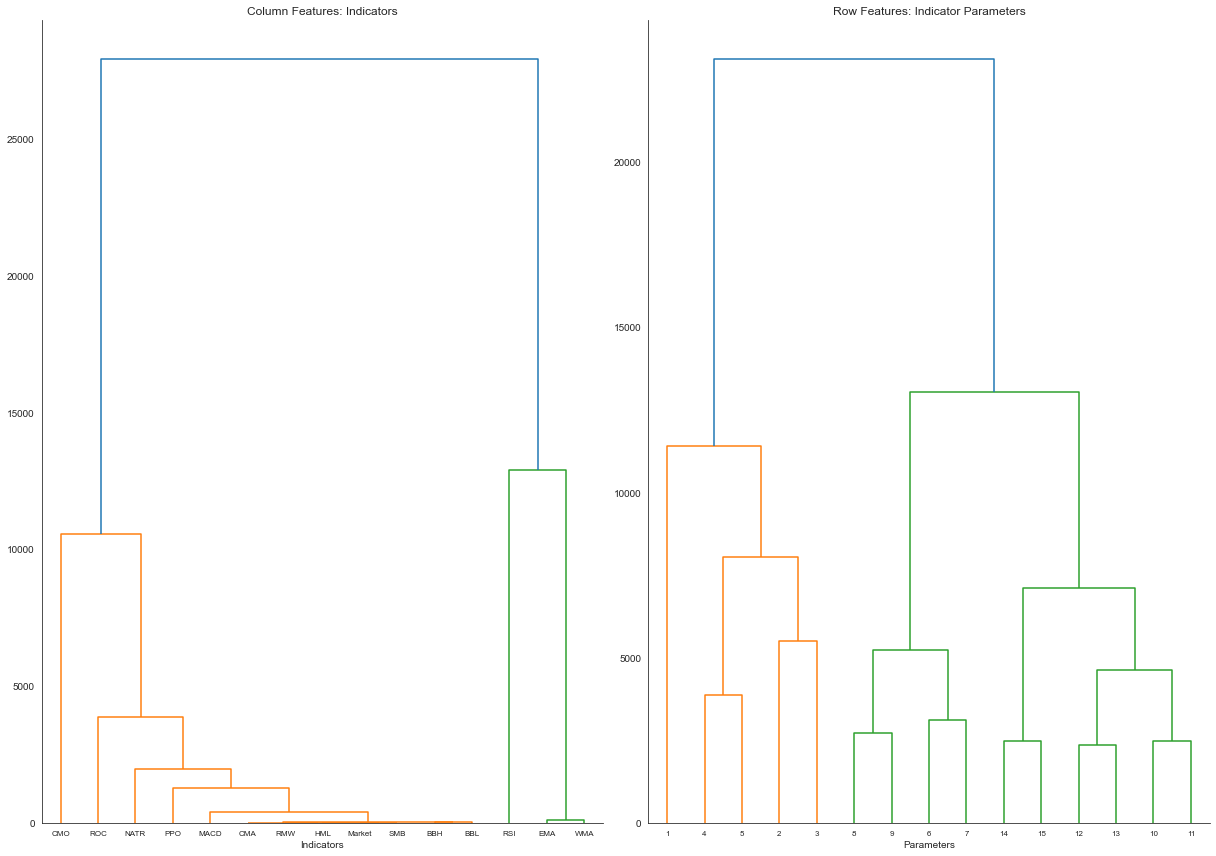

In [15]:
fig, axes = plt.subplots(figsize=(17, 12), ncols=2)

labels = sorted(best_features)
title = 'Column Features: Indicators'
col_order = cluster_features(features.dropna().values.reshape(-1, 15).T, labels, axes[0], title)

labels = list(range(1, 16))
title = 'Row Features: Indicator Parameters'
row_order = cluster_features(
    features.dropna().values.reshape(-1, 15, 15).transpose((0, 2, 1)).reshape(-1, 15).T,
    labels, axes[1], title)
axes[0].set_xlabel('Indicators')
axes[1].set_xlabel('Parameters')
sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'cnn_clustering', dpi=300)

In [16]:
feature_order = [f'{i:02}_{j}' for i in row_order for j in col_order]
features = features.loc[:, feature_order]
features = features.apply(pd.to_numeric, downcast='float')
features.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2416051 entries, ('A', Timestamp('2001-01-02 00:00:00')) to ('ZTS', Timestamp('2018-03-27 00:00:00'))
Columns: 225 entries, 01_CMO to 11_WMA
dtypes: float32(195), float64(30)
memory usage: 2.4+ GB


In [17]:
features

01_CMO    01_ROC   01_NATR    01_PPO   01_MACD  \
symbol date                                                            
A      2001-01-02 -34.412796 -0.973141  6.947728  0.585962  0.534434   
       2001-01-03  12.697194  2.633023  7.902791  1.489047  0.594177   
       2001-01-04  25.371769  8.878505  7.599194  2.874703  0.748755   
       2001-01-05  -0.667682 -1.573114  8.137382  2.481612  0.687998   
       2001-01-08 -12.974548 -3.724462  8.088328  1.464707  0.534037   
...                      ...       ...       ...       ...       ...   
ZTS    2018-03-21  11.500512 -0.579265  1.839422  2.810751  2.371858   
       2018-03-22 -27.581970 -2.714879  2.044189  2.072431  1.971583   
       2018-03-23 -44.337906 -4.829378  2.247168  1.164358  1.442348   
       2018-03-26   9.519835 -1.028369  2.453539  1.345641  1.409570   
       2018-03-27 -13.594762 -1.551413  2.750986  0.955138  1.121832   

                     01_CMA    01_RMW    01_HML  01_Market    01_SMB  ...  \
symbol date                                                           ...   
A      2001-01-02  0.025279 -0.006478 -0.016951   0.013758 -0.011674  ...   
       2001-01-03  0.014975 -0.008856 -0.018188   0.009819 -0.020037  ...   
       2001-01-04  0.005857 -0.002693 -0.021231   0.004036 -0.009937  ...   
       2001-01-05  0.000882 -0.003614 -0.013796   0.005879 -0.005555  ...   
       2001-01-08 -0.019798 -0.003292  0.017045   0.014734  0.015989  ...   
...                     ...       ...       ...        ...       ...  ...   
ZTS    2018-03-21  0.002340  0.002342 -0.010770   0.009186 -0.005371  ...   
       2018-03-22  0.003041  0.004505 -0.010516   0.011582 -0.006142  ...   
       2018-03-23  0.002294  0.004565 -0.008518   0.011154 -0.007578  ...   
       2018-03-26  0.001158  0.001748 -0.007059   0.010987 -0.009854  ...   
       2018-03-27  0.000800  0.002722 -0.008496   0.012179 -0.005963  ...   

                     11_CMA    11_RMW    11_HML  11_Market    11_SMB  \
symbol date                                                            
A      2001-01-02 -0.000318  0.001430 -0.002984   0.017752  0.008332   
       2001-01-03  0.000321  0.002027 -0.004751   0.017179  0.006739   
       2001-01-04 -0.000894  0.002713 -0.006307   0.016025  0.010261   
       2001-01-05 -0.001228  0.001167 -0.004730   0.016212  0.009304   
       2001-01-08  0.000942  0.001341 -0.005059   0.017432  0.010896   
...                     ...       ...       ...        ...       ...   
ZTS    2018-03-21  0.000139  0.003458 -0.005068   0.009918  0.000578   
       2018-03-22 -0.001250  0.004155 -0.004228   0.010327  0.001235   
       2018-03-23 -0.000956  0.004032 -0.004427   0.010242  0.001077   
       2018-03-26 -0.002575  0.004021 -0.003738   0.010542  0.001202   
       2018-03-27 -0.003096  0.003429 -0.003976   0.010567  0.001346   

                     11_BBH    11_BBL     11_RSI     11_EMA     11_WMA  
symbol date                                                             
A      2001-01-02  0.151378  0.004491  46.341988  36.953236  37.318766  
       2001-01-03  0.066146  0.090595  54.497822  37.110993  37.350420  
       2001-01-04  0.034141  0.120748  57.293777  37.420349  37.568837  
       2001-01-05  0.080985  0.075976  52.150497  37.437270  37.528706  
       2001-01-08  0.102645  0.049909  49.463108  37.306922  37.354283  
...                     ...       ...        ...        ...        ...  
ZTS    2018-03-21  0.023354  0.047221  61.863701  83.051051  83.781691  
       2018-03-22  0.045243  0.021501  52.919235  82.934457  83.661176  
       2018-03-23  0.061055  0.003426  47.658897  82.659815  83.360074  
       2018-03-26  0.026100  0.036231  57.353024  82.785719  83.426029  
       2018-03-27  0.047084  0.014856  51.298294  82.676811  83.253971  

[2416051 rows x 225 columns]

In [11]:
features.to_hdf('data/universe_data.h5', 'img_data')